In [1]:
import pandas as pd
import numpy as np

In [2]:
Switerland_spot = pd.read_csv("/Volumes/分区01/Data/Switerland.csv")
aes_forward = pd.read_csv("/Volumes/分区01/Switzerland Forward Monthly.csv")

In [3]:
aes_forward.index = pd.to_datetime(aes_forward['Date'])
#aes_forward["ym"] = 100*aes_forward["Date"].dt.year +aes_forward["Date"].dt.month
aes_forward=aes_forward.drop('Date',axis=1)
f = aes_forward.loc['2006/01/20':'2014/12/20',:]

In [4]:
Switerland_spot.index = pd.to_datetime(Switerland_spot["Date"])
#Switerland_spot["ym"] = 100*Switerland_spot["Date"].dt.year +Switerland_spot["Date"].dt.month
Switerland_spot = Switerland_spot.drop('Date',axis=1)
s = Switerland_spot.loc['2006-01-20':'2014-12-20',:]
s = s.iloc[:,0]

In [5]:
s = np.array(s).reshape((-1,1))
f = np.array(f).reshape((-1,1))
s.shape

(108, 1)

$$
f_t^{t+1} - s_t \\
$$

In [6]:
#fp = np.log(f) - np.log(s)
fp = np.log(f) -np.log(s)
fp = fp[1:,:]
fp.shape

(107, 1)

In [7]:
e = np.zeros((fp.shape[0],1))
e.shape

(107, 1)

$$
s_{t+1} - s_{t}\\
$$

In [8]:
#create a new title
ER = np.log(s[1:,:]) - np.log(s[:-1,:])
ER.shape


(107, 1)

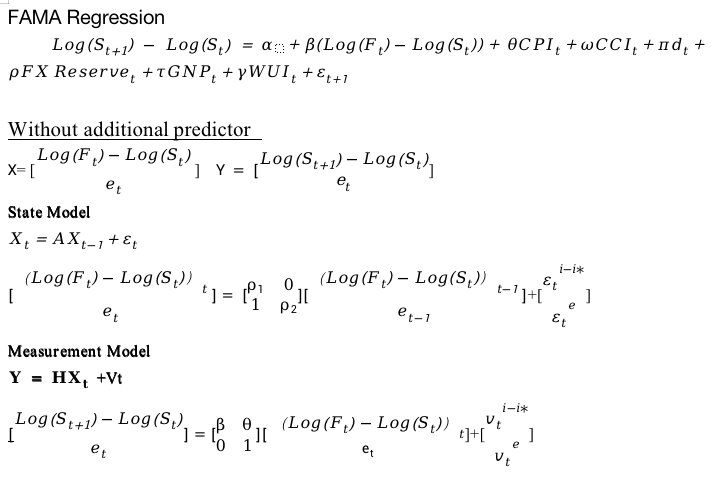



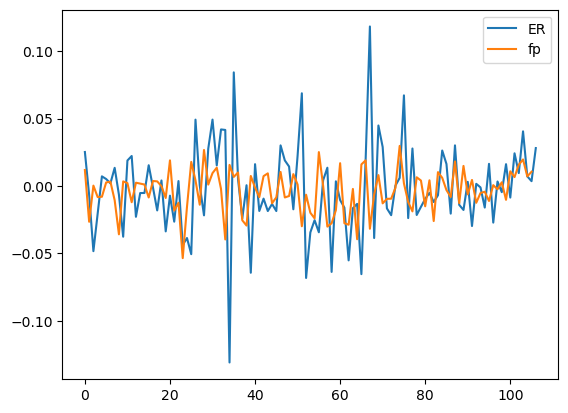

In [9]:
import matplotlib.pyplot as plt
plt.plot(ER, label="ER")
plt.plot(-fp[1:], label="fp")
plt.legend()
plt.show()

In [10]:
from scipy import linalg

X = np.hstack([-fp,e])
Y = np.hstack([ER,e])
A = np.array([[0.1,0],[0,1.2]]).reshape(2,2)
Q = np.array([[(1.5)**2,0],[0,1**2]])
P0 = np.array([[300,0],[0,300]])
P = A @ P0 @ A.T + Q
H = np.array([[1.2, 1.5],[0, 1]])
f0 = H @ P @ H.T

inv_f0 = linalg.inv(f0)
print(inv_f0)

[[ 0.13227513 -0.1984127 ]
 [-0.1984127   0.29992852]]


In [30]:
b0 = np.array([10.4, 9.8, 1.8, 3.3, 10.1, 10.1,0.5])

from scipy import linalg

def Logl(b):
    P0 = np.array([[2,0],[0,2]])
    e = np.zeros((fp.shape[0],1))
    #A
    A = np.array([[b[0],0],[1,b[1]]]).reshape(2,2)

    #initialize covariance matrix for state matrix P
    #initialy a large value
    cr21 = b[4]*b[5]*b[6]
    
    Q = np.array([[b[4]**2,cr21],
                [cr21, b[5]**2]])
    
    H = np.array([[b[2], b[3]],[0, 1]])

    # x= idiff, missing risk premium
    X = np.hstack([-fp,e])
    #X = X[1:,:]
    #e = e[1:,:]
    Y = np.hstack([ER,e])
    
    #     State model AR1
    # Measurement model
    eta = Y[1:,:] - X[1:,:] @ H

    l = np.zeros((X.shape[0]-1,))
    for i in range(0, X.shape[0]-1):
        X1 = (X[i,:] @ A).reshape((-1,1))
        X1[0, 0] = X[i+1, 0]
        Y1 = H @ X1
        eta = Y[i+1,:].reshape((-1,1)) - Y1
        P = A @ P0 @ A.T + Q
        f0 = H @ P @ H.T # ? not convertible
        
        inv_f0 = linalg.inv(f0)
      
        l[i] = -0.5 * np.log(2 *np.pi * np.linalg.det(f0)) -0.5 * eta.T @ inv_f0 @ eta
        X11 = X1 + P @ H.T @ np.linalg.inv(f0) @ eta
        P0 = P - P @ H.T @ np.linalg.inv(f0) @ H @ P
        
        X[i+1,-1] = X11[-1,0]
    return np.sum(l[10:,])

#change initial value
#change estimation method

In [31]:
#reconstruct state space model
#change the algorithm
#because the initial value of variance is too small, cause the determinants of f too small and not invertible, 
#I change the initial variance to 300 for P 

In [49]:
from scipy.optimize import minimize

def cons3(b):
    return b[4]
def cons4(b):
    return b[5]
b = [-1, 1]
bp = [0+1e-8, None]
bn = [None, None]

bnds = (b, b, bn, bn, bp, bp,b)
c3 = {'type': 'ineq', 'fun': cons3}
c4 = {'type': 'ineq', 'fun': cons4}
cons = [c3, c4]

b0 = np.array([0.8,0.9,.8, .3, 1.1, 1.6,0.8])
sol = minimize(Logl, b0, constraints=cons,method='SLSQP', bounds=bnds)

#method SLSQP：uses Sequential Least SQuares Programming to minimize a function of several variables with any combination of
# （continue） bounds, equality and inequality constraints

print(sol)

/var/folders/0z/gw445ym92fs4ypy0vxgmg9hm0000gn/T/ipykernel_6890/1410546703.py:41: RuntimeWarning: invalid value encountered in log
  l[i] = -0.5 * np.log(2 *np.pi * np.linalg.det(f0)) -0.5 * eta.T @ inv_f0 @ eta


     fun: -4586.091239337405
     jac: array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00012207])
 message: 'Optimization terminated successfully'
    nfev: 295
     nit: 36
    njev: 36
  status: 0
 success: True
       x: array([ 8.00000000e-01,  9.00000000e-01,  3.02847458e+06, -1.39695378e+01,
        5.17073555e+06,  1.42283938e+07,  8.90550541e-07])


In [53]:
b1 = np.array([8.00000000e-01,  9.00000000e-01,  3.02847458e+06, -1.39695378e+01,
        5.17073555e+06,  1.42283938e+07,  8.90550541e-07])

In [58]:
def est(b):
    P0 = np.array([[2,0],[0,2]])
    e = np.zeros((fp.shape[0],1))
    #A
    A = np.array([[b[0],0],[1,b[1]]]).reshape(2,2)

    #initialize covariance matrix for state matrix P
    #initialy a large value

    Q = np.array([[b[4]**2,0],[0,b[5]**2]]).reshape(2,2)
    H = np.array([[b[2], b[3]],[0, 1]])

    # x= idiff, missing risk premium
    X = np.hstack([-fp,e])
    #X = X[1:,:]
    #e = e[1:,:]
    Y = np.hstack([ER,e])
    
    #     State model AR1
    # Measurement model
    eta = Y[1:,:] - X[1:,:] @ H

    l = np.zeros((X.shape[0]-1,))
    for i in range(0, X.shape[0]-1):
        X1 = (X[i,:] @ A).reshape((-1,1))
        X1[0, 0] = X[i+1, 0]
        Y1 = H @ X1
        eta = Y[i+1,:].reshape((-1,1)) - Y1
        P = A @ P0 @ A.T + Q
        f0 = H @ P @ H.T # ? not convertible
        
        inv_f0 = linalg.inv(f0)
      
        l[i] = -0.5 * np.log(2 *np.pi * np.linalg.det(f0)) -0.5 * eta.T @ inv_f0 @ eta
        X11 = X1 + P @ H.T @ np.linalg.inv(f0) @ eta
        P0 = P - P @ H.T @ np.linalg.inv(f0) @ H @ P
        
        X[i+1,-1] = X11[-1,0]
        
    return X[:,1]


In [59]:
est(b1)   




array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.])

# With predictor (Switzerland)

In [60]:
#x log(F_t)-Log(S_t),et, government yield diff,FXR,WUI,GNP
#y 
import pandas as pd
bondr_swiss = pd.read_csv("/Volumes/分区01/Data Source/Olivia/10yr government bond yield Swiss.csv")
bondr_us = pd.read_csv("/Volumes/分区01/Data Source/Olivia/10 year government bond yield US.csv")
FXR = pd.read_csv("/Volumes/分区01/Data/Foreign Exchange Reserve/Switzerland.csv")
WUI = pd.read_csv("/Volumes/分区01/Data Source/Olivia/WUI.csv")
GNP = pd.read_csv("/Volumes/分区01/Data Source/Olivia/GNP Switzerland.csv")
CCI = pd.read_csv("/Volumes/分区01/New_CCI Switzerland.csv")

In [61]:
CCI.index = pd.to_datetime(CCI["DATE"])
CCI = CCI.drop(columns = ['DATE'])
CCI = CCI.loc['2006-02-01':'2014-12-20',:]

In [62]:
bondr_swiss.index = pd.to_datetime(bondr_swiss["DATE"])
bondr_swiss= bondr_swiss.drop(columns = ['DATE'])

In [63]:
#set time index
bondr_us.index = pd.to_datetime(bondr_us["DATE"])
bondr_us = bondr_us.drop(columns = ['DATE'])
FXR.index = pd.to_datetime(FXR["DATE"])
FXR = FXR.drop(columns = ["DATE"])
FXR = FXR.iloc[72:180,:]
WUI.index = pd.to_datetime(WUI["DATE"]).dt.to_period('M')
WUI = WUI.drop(columns = ["DATE"])
GNP.index = pd.to_datetime(GNP["DATE"]).dt.to_period('M')
GNP = GNP.drop(columns = ["DATE"])
GNP = GNP.iloc[:-2,:]


In [64]:
#us - switzerland
gov_bondr_diff = bondr_us["Bond Rate US"] - bondr_swiss["bond rate switzerland"]
gov_bondr_diff = gov_bondr_diff.to_frame()

In [65]:
#convert WUI and GNP from quarterly into monthly
#resampling

WUI = WUI.resample('1M').mean()
WUI['WUI'] = WUI[['WUI']].interpolate(method="linear")
           
GNP = GNP.resample('1M').mean()
GNP['Switzerland'] = GNP[['Switzerland']].interpolate()

In [66]:
WUI = WUI.iloc[:-1,:]

In [67]:
FXR = np.log(FXR.drop(labels= ["2006-01"]))
WUI = np.log(WUI.drop(labels= ["2006-01"]))
GNP = np.log(GNP.drop(labels= ["2015-01"]))
GNP = GNP.iloc[1:,:]
gov_bondr_diff = gov_bondr_diff.iloc[1:,:]

CCI = np.log(CCI)
WUI = np.log(WUI)

In [68]:
#stationary test

from statsmodels.tsa.stattools import adfuller

result = adfuller(FXR[['Switzerland']], maxlag=1)
print(result)

(-0.5683301942731331, 0.8779787440156552, 1, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -243.26688559735612)


In [69]:
# FXR = FXR.diff()
#non-stationary
FXR = FXR.dropna()
result = adfuller(FXR, maxlag=1)
print(result)

(-0.5683301942731331, 0.8779787440156552, 1, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -243.26688559735612)


In [70]:
result = adfuller(WUI, maxlag=1)
print(result)
#stationary

(-3.8697223590529326, 0.00226932503513349, 1, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -703.4498517033812)


In [71]:
result = adfuller(GNP, maxlag=1)
print(result)
#nonstationary

(-2.0341787321672418, 0.27179084009457943, 1, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -1056.4287005743972)


In [72]:
#take differential
#GNP = GNP.diff()
GNP = GNP.dropna()
result = adfuller(GNP, maxlag=1)
print(result)
#non-stationary

(-2.0341787321672418, 0.27179084009457943, 1, 105, {'1%': -3.4942202045135513, '5%': -2.889485291005291, '10%': -2.5816762131519275}, -1056.4287005743972)


In [73]:
result = adfuller(gov_bondr_diff, maxlag=1)
print(result)
#non-stationary

(-2.324518524646023, 0.16418214097998957, 0, 106, {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}, -55.44212821379358)


In [74]:
fp = fp[0:,:]
fp = np.array(fp)
e = np.zeros((fp.shape[0],1))
print(fp.shape)

(107, 1)


In [75]:
#X = np.hstack([-fp,e,gov_bondr_diff,FXR,GNP]) 
#Y = np.hstack([ER,e,gov_bondr_diff,,GNP])  

#drop nan terms
gov_bondr_diff = gov_bondr_diff.dropna()
FXR = FXR.dropna()
GNP = GNP.dropna() 

In [76]:
import numpy as np
b0 = np.array([5.1, 5.6, 6.1, 6.3, 5.9, 1.3,3.8,4.5,3.4,4.6,10.1,
               10.6,10.6,10.3,10.5,3.8,3.5])##17 + 27

def Logl(b):
    P0 = np.array([[2,0,0,0,0],
                   [0,2,0,0,0],
                   [0,0,2,0,0],
                   [0,0,0,2,0],
                   [0,0,0,0,2]])
    e = np.zeros((fp.shape[0],1))
    #A
    A = np.array([[b[0],0,0,0,0],
                  [0,b[1],0,0,0],
                  [0,0,b[2],0,0],
                  [0,0,0,b[3],0],
                  [0,0,0,0,b[4]]]).reshape(5,5) 

    #initialize covariance matrix for state matrix P
    #correlation between shocks
    
    cr21 = b[10]*b[11]*b[17]
    cr31 = b[10]*b[12]*b[18]
    cr41 = b[10]*b[13]*b[19]
    cr51 = b[10]*b[14]*b[20]
    cr32 = b[11]*b[12]*b[21]
    cr42 = b[11]*b[13]*b[22]
    cr52 = b[11]*b[14]*b[23]
    cr43 = b[12]*b[13]*b[24]
    cr53 = b[12]*b[14]*b[25]
    cr54 = b[13]*b[14]*b[26]
    
    Q = np.array([[b[10]**2,cr21,cr31,cr41,cr51],
                [cr21, b[11]**2,cr32,cr42,cr52],
                [cr31,cr32,b[12]**2,cr43,cr53],
                [cr41,cr42,cr43,b[13]**2,cr54],
                [cr51,cr52,cr53,cr54,b[14]**2]])
     
    H = np.array([[b[5], b[6],b[7],b[8],b[9]],
                  [0,1,0,0,0],
                  [0,0,1,0,0],
                  [0,0,0,1,0],
                  [0,0,0,0,1]]) 
    T0 = np.array([[b[15],b[16],0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0]])
    
    # x= idiff, missing risk premium
    X = np.hstack([-fp,e,gov_bondr_diff,FXR,GNP]) 
    #X = X[1:,:]
   # e = e[1:,:]
    Y = np.hstack([ER,e,gov_bondr_diff,FXR,GNP])  
   #F (exogenous)
    zero = np.array([np.zeros(107)]).reshape(107,1)
    F = np.hstack([CCI,WUI,zero,zero,zero]) 
    
    # Measurement model
    #eta = Y[1:,:] - X[1:,:] @ H - F[1:,:]@ T0 

    l = np.zeros((X.shape[0]-1,))
    for i in range(0, X.shape[0]-1):
        X1 = (X[i,:] @ A).reshape((-1,1)) 
        X1[2:, 0] = X[i+1, 2:]
         
        Y1 = H @ X1 +  (T0 @ F[i+1,:].T).reshape((-1,1))
        eta = Y[i+1,:].reshape((-1,1)) - Y1
        
        P = A @ P0 @ A.T + Q
        f0 = H @ P @ H.T
        inv_f0 = np.linalg.inv(f0)
      
        l[i] = -0.5 * np.log(2 *np.pi * np.linalg.det(f0)) -0.5 * eta.T @ inv_f0 @ eta
        X11 = X1 + P @ H.T @ np.linalg.inv(f0) @ eta
        P0 = P - P @ H.T @ np.linalg.inv(f0) @ H @ P
        
        X[i+1,1] = X11[1,0]
        #print(X)
    return -np.sum(l[10:])




In [77]:
from scipy.optimize import minimize

def cons3(b):
    return b[10]
def cons4(b):
    return b[11]
def cons5(b):
    return b[12]
def cons6(b):
    return b[13]
def cons7(b):
    return b[14]

#-1,1
b = [-1, 1]
bp = [0+1e-8, None]
bn = [None, None]


bnds = (b, b, b, b, b,bn,bn,bn,bn,bn,bp,bp,bp,bp,bp,bn,bn, b, b, b, b, b, b, b, b, b, b)
c3 = {'type': 'ineq', 'fun': cons3}
c4 = {'type': 'ineq', 'fun': cons4}
c5 = {'type': 'ineq', 'fun': cons5}
c6 = {'type': 'ineq', 'fun': cons6}
c7 = {'type': 'ineq', 'fun': cons7}

cons = [c3, c4, c5, c6, c7]

#b0 = np.array([0.7, 20.7, 19.8, 20.9, 20.4, 2.3,5.5,5.5,5.4,5.6,10.1,10.6,10.6,10.3,10.5,8.8,8.5,1.8,1.4,1.6,1.2,1.5,1.7,1.9,1.6,1.7,1.3]) 
b0 = np.array([.8, .4,.5, .5,.2, .5,.2,.9,.1,.5, .06,.06,.05,.07,.08,1.5,1.5,.4, .5, .4, .6, -.5, .5, -.1, -.5, .1, .1])
sol = minimize(Logl, b0, constraints=cons,method='Powell', bounds=bnds)



/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minimize.py:569: RuntimeWarning: Method Powell cannot handle constraints.
  warn('Method %s cannot handle constraints.' % method,
/var/folders/0z/gw445ym92fs4ypy0vxgmg9hm0000gn/T/ipykernel_6890/456827855.py:74: RuntimeWarning: invalid value encountered in log
  l[i] = -0.5 * np.log(2 *np.pi * np.linalg.det(f0)) -0.5 * eta.T @ inv_f0 @ eta


In [78]:
print(sol)

   direc: array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [79]:
Xest1 = np.array([])
def est(b):
    P0 = np.array([[2,0,0,0,0],
                   [0,2,0,0,0],
                   [0,0,2,0,0],
                   [0,0,0,2,0],
                   [0,0,0,0,2]])
    e = np.zeros((fp.shape[0],1))
    #A
    A = np.array([[b[0],0,0,0,0],
                  [0,b[1],0,0,0],
                  [0,0,b[2],0,0],
                  [0,0,0,b[3],0],
                  [0,0,0,0,b[4]]]).reshape(5,5) 

    #initialize covariance matrix for state matrix P
    #correlation between shocks
    
    cr21 = b[10]*b[11]*b[17]
    cr31 = b[10]*b[12]*b[18]
    cr41 = b[10]*b[13]*b[19]
    cr51 = b[10]*b[14]*b[20]
    cr32 = b[11]*b[12]*b[21]
    cr42 = b[11]*b[13]*b[22]
    cr52 = b[11]*b[14]*b[23]
    cr43 = b[12]*b[13]*b[24]
    cr53 = b[12]*b[14]*b[25]
    cr54 = b[13]*b[14]*b[26]
    
    Q = np.array([[b[10]**2,cr21,cr31,cr41,cr51],
                [cr21, b[11]**2,cr32,cr42,cr52],
                [cr31,cr32,b[12]**2,cr43,cr53],
                [cr41,cr42,cr43,b[13]**2,cr54],
                [cr51,cr52,cr53,cr54,b[14]**2]])
     
    H = np.array([[b[5], b[6],b[7],b[8],b[9]],
                  [0,1,0,0,0],
                  [0,0,1,0,0],
                  [0,0,0,1,0],
                  [0,0,0,0,1]]) 
    T0 = np.array([[b[15],b[16],0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0],
                   [0,0,0,0,0]])
    
    # x= idiff, missing risk premium
    X = np.hstack([-fp,e,gov_bondr_diff,FXR,GNP]) 
    #X = X[1:,:]
   # e = e[1:,:]
    Y = np.hstack([ER,e,gov_bondr_diff,FXR,GNP])  
   #F (exogenous)
    zero = np.array([np.zeros(107)]).reshape(107,1)
    F = np.hstack([CCI,WUI,zero,zero,zero]) 
    
    # Measurement model
    #eta = Y[1:,:] - X[1:,:] @ H - F[1:,:]@ T0 

    l = np.zeros((X.shape[0]-1,))
    for i in range(0, X.shape[0]-1):
        X1 = (X[i,:] @ A).reshape((-1,1)) 
        X1[2:, 0] = X[i+1, 2:]
         
        Y1 = H @ X1 +  (T0 @ F[i+1,:].T).reshape((-1,1))
        eta = Y[i+1,:].reshape((-1,1)) - Y1
        
        P = A @ P0 @ A.T + Q
        f0 = H @ P @ H.T
        inv_f0 = np.linalg.inv(f0)
      
        l[i] = -0.5 * np.log(2 *np.pi * np.linalg.det(f0)) -0.5 * eta.T @ inv_f0 @ eta
        X11 = X1 + P @ H.T @ np.linalg.inv(f0) @ eta
        P0 = P - P @ H.T @ np.linalg.inv(f0) @ H @ P
        
        X[i+1,1] = X11[1,0]
        #print(X[:,1])
    return X[:,1]
    


In [80]:
#from empirical results
b2 = np.array([9.48487572e-01,  5.29330320e-01,  1.88534549e-01, -5.27864045e-01,
        2.43891385e-01,  4.14173152e+02,  6.44040478e+00, -8.07186813e+01,
        7.01541314e-02,  3.00580516e+00,  1.55688706e-01,  6.41896252e-05,
        6.41896252e-05,  6.41896252e-05,  6.41896252e-05,  4.10771606e+00,
        3.96662624e+00, -2.35780203e-01, -2.36067977e-01, -2.36067977e-01,
       -2.36067977e-01, -2.36067977e-01,  2.97454763e-01, -2.36067977e-01,
        2.91296091e-01, -2.36067977e-01,  5.45634144e-01])

In [81]:
#missing risk premium
est(b2)


array([ 0.00000000e+00, -1.14421622e-19, -1.56481808e-34, -4.04852401e-20,
        1.23806958e-19, -2.28704181e-34,  1.38947853e-19,  6.01853108e-35,
       -5.90724371e-20, -3.26013705e-20, -1.51890170e-19, -2.62195234e-20,
       -2.71723786e-20, -1.90487841e-20, -5.30351620e-20,  1.19314412e-20,
       -1.84475500e-20,  1.95434721e-20, -2.48206247e-20,  8.86179511e-21,
       -4.40127052e-20, -2.48427058e-21,  1.58327863e-20, -4.82508359e-20,
       -2.11738274e-20, -6.40110605e-20,  2.89733945e-20, -8.73623155e-20,
        5.85718863e-20,  3.06512166e-20,  7.40710267e-20, -1.17678908e-20,
       -1.23167992e-20, -6.01853108e-36,  7.39285566e-20, -2.97474503e-20,
        5.08296770e-20,  1.02798478e-19, -6.96076569e-20, -1.66604172e-20,
        7.52316385e-36, -6.78310298e-21, -1.44900607e-20, -1.35416949e-35,
        7.52698064e-21, -1.07957355e-21,  1.06758691e-20, -1.34128661e-20,
       -1.16187684e-20,  3.15156700e-20, -2.20649323e-20,  2.98329741e-20,
       -1.06681473e-20,  